# A TUTORIAL INTRODUCTION TO THE METROPOLIS-HASTINGS ALGORITHM

by Sebastian T. Glavind, August 2022

In [1]:
import numpy as np
import scipy
import scipy.stats as stats
from matplotlib import pyplot as plt
%matplotlib inline

print('Versions: numpy, ', np.__version__,'; scipy, ', scipy.__version__)

Versions: numpy,  1.22.3 ; scipy,  1.7.3


# Introduction

This tutorial introduces the fundamental Markov Chain Monte Carlo (MCMC) algorithm named Metropolis-Hastings (MH) after the inventers, thus it originates from the Metropolis algorithm due to Metropolis and co-workers and was later generalized by Hastings, leading to the so-called Metropolis–Hastings algorithm. MCMC simulation allows for efficient generation of random samples according to an arbitrary target probability distribution, where the samples are generated as a sequence of a Markov chain, which is a stochastic process that obeys the Markov poperty, i.e., a future state is independent of previous states given the current state. The primary property of the sample distribution resulting from MCMC simulation is that it either immediately resembles the target distribution or converges to it as the Markov chain evolves, and thus statistical inferences made based on the sample distribution is asymptotically unbiased (Au & Wang, 2014). As an example, MCMC simulation remains the only avaliable tool for full Baysian inference in a non-conjugate setting. 

------------

Au, S. K., & Wang, Y. (2014). Engineering risk assessment with subset simulation. John Wiley & Sons.

------------

# The fundamental Metropolis-Hastings algorithm

As mentioned above, MCMC methods approximate the target distribution using samples. These samples are generally generated by accepting or rejecting samples from a different distribution, namely the so-called the proposal distribution. In this regred, even when we do not know what the entire (unnormalized) target distribution looks like, we need to be able to evaluate it point-wise in order to judge whether a given proposal state should be accepted or not.

The MH algorithm associated with the target distribution $p(x^*)$ and the conditional, proposal distribution $q(x^*|x^{(t)})$ produces a Markov chain $\{ x^{(t)} \}_{t=0}^T$ by successively applying the following transition kernel $K$, such that $x^{(t+1)}|x^{(0:t)} \sim K(x^{(t)}, x^{(t+1)})$, where $(0:t) = \{0, 1, 2, ..., t\}$.

<div class="alert alert-block alert-info">

<p><strong>Metropolis-Hastings transition kernel</strong></p>

<p>
1. Given the current state $x^{(t)}$, generate a new proposal state $x^* \sim q(x^*|x^{(t)})$
</p>    

<p>
2. Compute the acceptance probability of the proposed state as
$$
p_{acc}(x^*|x^{(t)}) = \min \left\{ 1, r_{acc} \right\}, \text{where} \ r_{acc} = \frac{p(x^*) q(x^{(t)}|x^*)}{p(x^{(t)}) q(x^*|x^{(t)})},
$$
</p>

<p>
3. Generate the next state as
$$
x^{(t+1)} =
\begin{cases}
x^* & \text{if } p_{acc} > u, \ u \sim \mathcal{U}(0,1) \\
x^{(t)} & \text{otherwise}
\end{cases}
$$
where $\mathcal{U}(0,1)$ the uniform distribution defined over the range $[0,1]$.
</p>
</div>

It can be shown (e.g., Robert, C. P. & Casella, G., 2010; Martin et al. (2022)) that the MH transition kernel $K$ satisfies the so-called detailed balance condition, i.e.,

$$
p(x) K(y|x) = p(y) K(x|y),
$$

which ensures that the kernel produces a reversible Markov chain with stationary distribution $p$. A special case is found if the proposal distribution $q$ in the MH algorithm is chosen to be symmetric. For this case, the terms $q(x^{(t)}|x^*)$ and $q(x^*|x^{(t)})$ in $r_{acc}$ will cancel out, which leads to the original Metropolis algorithm, where $r_{acc}$ is simply defined as the ratio of the target distribution evaluated at the proposal value $x^*$ and the current state $x^{(t)}$, respectively. Another special case is the so-called Gibbs sampler in which the newly proposed state is always accepted with probability one. The basic idea of Gibbs sampling is to iterately sample from the conditional distribution of each coordinate of the target distribution, given a realization of the remaining coordinates. The main advantage of Gibbs sampling is obviously that proposals are always accepted, but the main disadvantage is that we need to be able to derive the above conditional probability distributions, which is only tractable in a conjugate setting. For further details, the reader is referred to e.g., Gelman et al. (2013).

---------

Gelman, A., Carlin, J.B., Stern, H.S., Dunson, D.B., Vehtari, A., & Rubin, D.B. (2013). Bayesian Data Analysis (3rd ed.). Chapman and Hall/CRC.

Martin, O. A., Kumar, R., & Lao, J. (2022). Bayesian Modeling and Computation in Python. Chapman and Hall/CRC.

Robert, C. P. & Casella, G. (2010). Introducing monte carlo methods with r. Springer.

---------

In [2]:
# Metropolis-Hastings algorithm
def MetropolisHastings(x, T, log_pos, proposal, delta=1):
    """
    Metropolis-Hastings algorithm: 
    x - starting position (np.array([dim]))
    T - No. of MCMC simulations
    log_pos - log-posterior distribution (callable function)
    proposal - proposal distribution (callable function)
    delta - step size for proposal distribution
    """
    counter=0
    dim = len(x)  
    samp = np.zeros([T, dim])
    samp[0,:] = x
    lpos_cur = log_pos(x) # compute target density for current value
    for t in range(1,T,1):
        # Generate proposal 
        x_pro, log_pro_ratio = proposal(samp[t-1,:], delta) # compute Hastings correction for (x, x_pro)
        lpos_pro = log_pos(x_pro) # compute target density for proposal value
        # Generate next target sample
        ratio_pro = lpos_pro - lpos_cur + log_pro_ratio
        if np.log(np.random.uniform()) < ratio_pro: 
            counter += 1
            samp[t] = x_pro
            lpos_cur = lpos_pro
        else:
            samp[t,:] = samp[t-1,:]
    return(samp, counter)

# Independent-component MH algorithm

The fundamental MH algorithm is not applicable in high-dimensional problems, as the acceptance ratio systematically tends to zero, see Au and Wang (2014; sec. 4.5). To cope with this problem, the independent-component HM algorithm generate the components one-by-one through a series of independent, one-dimensional MH transition kernels. Note that this algorithm is also referred to as Metropolis(-Hastings) within Gibbs, or elementwise Metropolis(-Hastings), see e.g., Gelman et al. (2013).

<div class="alert alert-block alert-info">

<p><strong>Independent-component MH transition kernel</strong></p>

<p>
$For \ i= 1, ..., M$ (each component)
</p>

<p>
1. Given the current state $x_i^{(t)}$, generate a new proposal state $x_i^* \sim q_i(x_i^*|x_i^{(t)})$
<p>

<p>
2. Compute the acceptance probability of the proposed state as
$$
p_{acc, i}(x^*|x^{(t)}) = \min \left\{ 1, r_{acc, i} \right\}, \text{where} \ r_{acc, i} = \frac{p(x^*) q_i(x_i^{(t)}|x_i^*)}{p(x) q_i(x_i^*|x_i^{(t)})},
$$
where $x = \{ x_1^{(t+1)}, ...,  x_{i-1}^{(t+1)},  x_{i}^{(t)},  x_{i+1}^{(t)}, ...,  x_M^{(t+1)}  \}$, and $x = \{ x_1^{(t+1)}, ...,  x_{i-1}^{(t+1)},  x_{i}^*,  x_{i+1}^{(t)}, ...,  x_M^{(t+1)}  \}$.
</p>

<p>    
3. Generate the next state as
$$
x_i^{(t+1)} =
\begin{cases}
x_i^* & \text{if } p_{acc, i} > u, \ u \sim \mathcal{U}(0,1) \\
x_i^{(t)} & \text{otherwise}
\end{cases}
$$
where $\mathcal{U}(0,1)$ the uniform distribution defined over the range $[0,1]$.
</p>
    
<p>
$End$
</p>
</div>

Note that a random ordering of the $M$ elements of $X$ is chosen at each iteration $t$ to preserve reversibility of the chain.

In [3]:
# Independent-component Metropolis-Hastings algorithm
def ICMetropolisHastings(x, T, log_pos, proposal, Hastings, delta):
    """
    Independent-component MH algorithm: 
    x - starting position (np.array([dim]))
    T - No. of MCMC simulations
    log_pos - log-posterior distribution (callable function)
    proposal - proposal distribution (callable function)
    Hastings - Hastings correction (callable function)
    delta - step size for proposal distribution (vector)
    """
    dim = len(x)  
    counter = np.zeros(dim)
    samp = np.zeros([T, dim])
    samp[0,:] = x
    comp_vec = np.arange(0, dim, 1)
    for t in range(1,T,1):
        innov = proposal(samp[t-1,:], delta) # generate proposal innovations along each dimension - they are independent of each other and can be sampled up-front
        x_new = samp[t-1] # pre-define new state
        lpos_cur = log_pos(x_new) # compute target density for current state
        order = np.random.permutation(comp_vec) # random order for iteration t
        for m in order:
            x_pro = x_new.copy() # pre-define proposal
            x_pro[m] = innov[m] # introduce innovation for coordinate m
            lpos_pro = log_pos(x_pro) # compute target density for proposal value
            log_pro_ratio = Hastings(x_new, x_pro, m, delta)
            # Generate next target sample
            ratio_pro = lpos_pro - lpos_cur + log_pro_ratio
            if np.log(np.random.uniform()) < ratio_pro: 
                counter[m] += 1
                x_new = x_pro
                lpos_cur = lpos_pro
        samp[t,:] = x_new # book keeping
    return(samp, counter)

# Case I: Fitting the parameters of a univeriate Gaussian distribution

For the sake of illustration, we will consider the fitting of a univeriate Gaussian distribution $\mathcal{N}(\mu, \sigma^2)$ based on an observed data sample $\mathcal{D}$. Thus, we are interested in finding the mean value $\mu$ and variance $\sigma^2$ of the distribution. That is, our target is the joint distribution of the parameters $\boldsymbol\theta = \{ \mu, \sigma^2\}$.

## Plotting the objective function and observations

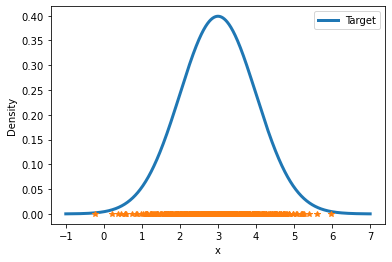

In [4]:
np.random.seed(123)
Nobs1 = 500
mu_obj1, sig_obj1 = 3, 1
xv1 = np.linspace(-1, 7, 1000)
yv1 = stats.norm(mu_obj1, sig_obj1).pdf(xv1)
Yobs1 = np.random.normal(mu_obj1, sig_obj1, size=Nobs1)

plt.plot(xv1,yv1, linewidth=3)
plt.plot(Yobs1, np.zeros(len(Yobs1)), '*')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend(['Target'])
plt.show()

## Target distribution

The target distribution for this assessment is the unnormalized parameter posterior distribution, which is composed of the data likelihood and weakly infromative Gaussian and Gamma distributed parameter priors, respectively, i.e.,

$$
p(\boldsymbol\theta|\mathcal{D}) \propto \mathcal{N}(y|\mu, \sigma) \mathcal{N}(\mu|0,10) \mathcal{Gam}(\sigma|2,2)
$$

Note that we use the log-transform of the expression above for numerical stability.

In [5]:
def log_pos1(pam, data=Yobs1):
    mu = pam[0]; sig = pam[1]
    logPos = (sum( stats.norm(loc = mu, scale=sig).logpdf(data.T) )
              + stats.norm(loc = 0, scale = 10).logpdf(mu)
              + stats.gamma(a = 2, scale = 2).logpdf(sig)
                 ) 
    return(logPos)

# log_pos(np.array([3.,1.]), Yobs) # test implementation

## Sampling using the fundamental MH algorithm

### Proposal distribution

As discussed above, our parameter space is $\boldsymbol\theta = \{ \mu, \sigma^2\}$, where $\mu \in \mathbb{R}$ and $\sigma^2 \in \mathbb{R}^+$, and thus we chose to employ a Gaussian proposal for $\mu$ and a log-Normal proposal for $\sigma^2$, which are samples independently, i.e., $\mu$ and $\sigma^2$ are independent in the proposal.

In [6]:
def logNorm2Norm_parameters(lm ,ls):
    phi = np.sqrt( ls**2 + lm**2 )
    nm = 2 * np.log(lm) - np.log(phi)  # mean of log(Y) 
    ns = np.sqrt( 2*np.log(phi) - 2*np.log(lm) ) # std dev of log(Y)
    return(nm,ns)

def density_norm_lnorm(x, mu, sig):
    log_dens = (stats.norm(mu[0],sig[0]).logpdf(x[0]) + 
                stats.lognorm(s=sig[1], scale=np.exp(mu[1])).logpdf(x[1]))
    return(log_dens)
    
def proposal_norm_lnorm(x, delta):
    # log-norm parameters for 2nd parameter of x[1]
    mlx, slx = logNorm2Norm_parameters(x[1], delta)
    # sample in normal space and transform for x_pro
    x_pro = np.array([x[0], mlx]) + np.random.normal(size=2) * np.array([delta, slx])
    # exponentiate 2nd coordinate of x_pro
    x_pro[1] = np.exp(x_pro[1])
    # log-norm parameters for 2nd parameter of x_pro[1]
    mlx_pro, slx_pro = logNorm2Norm_parameters(x_pro[1], delta)
    # Hastings correction
    log_dens_x_pro_x = density_norm_lnorm(x=x_pro, mu=[x[0], mlx], sig=[delta, slx]) # q(x_pro|x)
    log_dens_x_x_pro = density_norm_lnorm(x=x, mu=[x_pro[0], mlx_pro], sig=[delta, slx_pro]) # q(x|x_pro)
    log_pro_ratio = log_dens_x_x_pro - log_dens_x_pro_x # Hastings correction
    return(x_pro, log_pro_ratio)

### Sampling from target distribution

In [7]:
# Sampling
np.random.seed(42)
xinit1=np.array([1.,0.2]); T1=10000
samp1, counter1 = MetropolisHastings(xinit1, T1, log_pos1, proposal_norm_lnorm, delta=0.05)
print('Acceptance rate: ' , np.round(counter1/T1,3))

Acceptance rate:  0.445


### Plot posterior samples

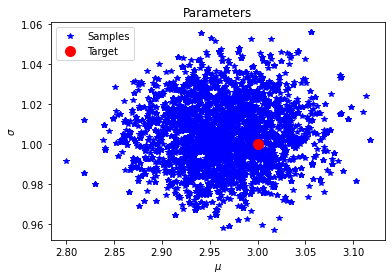

In [8]:
# Plot mean samples
def plot_samp1(samp):
    plt.plot(samp[T1//2:,0],np.sqrt(samp[T1//2:,1]),'*b') # a little burn-in is introduced.
    plt.plot( 3, 1,'or', markersize=10) # a little burn-in is introduced.
    # plt.xlim([1.75, 2.15])
    # plt.ylim([2.85, 3.16])
    plt.xlabel('$\mu$');
    plt.ylabel('$\sigma$');
    plt.title('Parameters')
    plt.legend(['Samples', 'Target'])
    
plot_samp1(samp1)

We see that the sampler assigns a high posterior density to the target parameters, i.e., we only observe a minor bias between the target parameters and the posterior mode.

## Sampling using the independent-component MH algorithm

### Proposal distribution

Again, our parameter space is $\boldsymbol\theta = \{ \mu, \sigma^2\}$, where $\mu \in \mathbb{R}$ and $\sigma^2 \in \mathbb{R}^+$, and thus we chose to employ a Gaussian proposal for $\mu$ and a log-Normal proposal for $\sigma^2$, which are samples independently, i.e., $\mu$ and $\sigma^2$ are independent in the proposal.

In [9]:
def independent_density_norm_lnorm(x, comp, mu, sig):
    if comp==0: # for 1st component (Gaussian)
        log_dens = stats.norm(mu,sig).logpdf(x)
    else: # for 2nd component (log-normal)
        log_dens = stats.lognorm(s=sig, scale=np.exp(mu)).logpdf(x)
    return(log_dens)

def independent_proposal_norm_lnorm(x, delta):
    # log-norm parameters for 2nd parameter of x[1]
    mlx, slx = logNorm2Norm_parameters(x[1], delta[1])
    # sample in normal space and transform for x_pro
    x_pro = np.array([x[0], mlx]) + np.random.normal(size=2) * np.array([delta[0], slx])
    # exponentiate 2nd coordinate of x_pro
    x_pro[1] = np.exp(x_pro[1])
    return(x_pro)

def independent_Hastings_correction(x, x_pro, comp, delta):
    if comp==0:
        # Univeriate densities
        # log_dens_x_pro_x = independent_density_norm_lnorm(x=x_pro[0], comp=0, mu=x[0], sig=delta[0]) # q(x_pro|x)
        # log_dens_x_x_pro = independent_density_norm_lnorm(x=x[0], comp=0, mu=x_pro[0], sig=delta[0]) # q(x|x_pro)
        # log_pro_ratio = log_dens_x_x_pro - log_dens_x_pro_x # Hastings correction
        log_pro_ratio = 0 # the Gaussian is symmetric, thus the log-Hastings correction is 0 
    else:
        # log-norm parameters for 2nd parameter of x[1]
        mlx, slx = logNorm2Norm_parameters(x[1], delta[1])
        # log-norm parameters for 2nd parameter of x_pro[1]
        mlx_pro, slx_pro = logNorm2Norm_parameters(x_pro[1], delta[1])
        # Univeriate densities 
        log_dens_x_pro_x = independent_density_norm_lnorm(x=x_pro[1], comp=1, mu=mlx, sig=slx) # q(x_pro|x)
        log_dens_x_x_pro = independent_density_norm_lnorm(x=x[1], comp=1, mu=mlx_pro, sig=slx_pro) # q(x|x_pro)
        log_pro_ratio = log_dens_x_x_pro - log_dens_x_pro_x # Hastings correction
    return(log_pro_ratio)

### Sampling from target distribution

In [10]:
# Sampling
np.random.seed(42)
xinit2=np.array([1.,0.2]); T2=10000
samp2, counter2 = ICMetropolisHastings(xinit2, T2, log_pos1, independent_proposal_norm_lnorm, independent_Hastings_correction, delta=np.array([0.1, 0.075]))
print('Acceptance rate: ' , np.round(counter2/T2,3))

Acceptance rate:  [0.467 0.451]


### Plot posterior samples

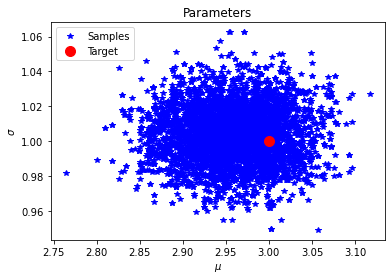

In [11]:
plot_samp1(samp2)